In [82]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time
import matplotlib.pyplot as plt

In [42]:
img=256
img_size=[img,img]

numOfClasses=26
batchSize=32
Epochs=1

In [43]:
model= tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(50,(2,2), input_shape=(img,img,1)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(70,(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(70,(3,3)),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(numOfClasses, activation="softmax")

])

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [44]:
print(model.summary())

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 63, 63, 50)     │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 63, 63, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 31, 31, 50)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 31, 31, 50)     │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 29, 29, 70)     │        31,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 29, 29, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 70)     │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 12, 70)     │        44,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 12, 12, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 70)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 70)       │           280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2520)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2520)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       645,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │         6,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 728,808 (2.78 MB)

 Trainable params: 728,428 (2.78 MB)

 Non-trainable params: 380 (1.48 KB)

None


In [52]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [46]:
trainFolder=r"train"
testFolder=r"validation"

In [47]:
train_datagen=ImageDataGenerator(rescale=1. / 255,
                                 rotation_range=20,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 shear_range=0.1,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
training_set=train_datagen.flow_from_directory(trainFolder,
                                               shuffle=True,
                                               target_size=img_size,
                                               batch_size=batchSize,
                                               class_mode="categorical",
                                               color_mode="grayscale")

Found 8605 images belonging to 26 classes.


In [48]:
test_datagen=ImageDataGenerator(rescale=1. / 255)
test_set=test_datagen.flow_from_directory(testFolder,
                                            shuffle=False,
                                            target_size=img_size,
                                            batch_size=batchSize,
                                            class_mode="categorical",
                                            color_mode="grayscale")

Found 1024 images belonging to 26 classes.


In [81]:
class_weights_dict

{0: 3.0887179487179486,
 1: 3.3573021181716833,
 2: 0.1252860173898573,
 3: 0.23375766514010712,
 4: 1.8097956730769231,
 5: 3.6195913461538463,
 6: 2.4909015715467326,
 7: 1.979947403024326,
 8: 2.1854136429608126,
 9: 2.2490664675130696,
 10: 0.977442388834794,
 11: 0.836295473479589,
 12: 1.7549533799533799,
 13: 2.1252646436132676,
 14: 3.173340358271865,
 15: 2.1449430199430197,
 16: 2.693649373881932,
 17: 1.2256817256817256,
 18: 2.5456466610312765,
 19: 2.33993783993784,
 20: 5.035953177257525,
 21: 3.21741452991453,
 22: 2.8956730769230767,
 23: 0.8944163944163944,
 24: 4.064102564102564,
 25: 0.4515669515669516}

In [49]:
stepsPerEpochs = int(np.ceil(training_set.samples / batchSize))
validationSteps = int(np.ceil(test_set.samples / batchSize))


# OJO CON EL .KERAS O .H5

In [50]:
model_file="train_model/model1.keras"
bestModel=ModelCheckpoint(model_file, monitor="val_accuracy", verbose=1, save_best_only=True)

In [84]:
class_indices = training_set.classes
clases = np.unique(class_indices)
class_weights = compute_class_weight(class_weight='balanced', classes=clases, y=training_set.classes)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

{0: 3.152014652014652, 1: 3.3096153846153844, 2: 0.12474992026443214, 3: 0.23127990109122185, 4: 1.9020778072502211, 5: 3.677350427350427, 6: 2.5458579881656807, 7: 1.8912087912087912, 8: 2.1631473102061336, 9: 2.2668598524762906, 10: 0.9483138637866432, 11: 0.8464489474719654, 12: 1.751119251119251, 13: 2.0685096153846154, 14: 3.093098490294752, 15: 2.3144163528778914, 16: 2.7580128205128207, 17: 1.2729289940828403, 18: 2.6266788766788767, 19: 2.330715059588299, 20: 5.171274038461538, 21: 2.9550137362637363, 22: 2.8531167108753315, 23: 0.8993520066889632, 24: 4.085944919278252, 25: 0.4596688034188034}


In [53]:
history=model.fit(
    training_set,
    validation_data=test_set,
    epochs=Epochs,
    steps_per_epoch=stepsPerEpochs,
    validation_steps=validationSteps,
    verbose=1,
    callbacks=[bestModel],
    class_weight=class_weights_dict
)

C:\Users\zapat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


269/269 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5663 - loss: 1.5388
Epoch 1: val_accuracy improved from -inf to 0.30371, saving model to train_model/model1.keras
269/269 ━━━━━━━━━━━━━━━━━━━━ 71s 251ms/step - accuracy: 0.5666 - loss: 1.5372 - val_accuracy: 0.3037 - val_loss: 6.9653


In [54]:
valResults=model.evaluate(test_set)
print(valResults)
print(model.metrics_names)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5449 - loss: 3.6587
[6.965299606323242, 0.3037109375]
['loss', 'compile_metrics']


display results on charts

In [55]:
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]
loss=history.history["loss"]
val_loss=history.history["val_loss"]

In [56]:
actualEpochs=range(len(acc))
print(f"actual epochs: {str(actualEpochs)}")

actual epochs: range(0, 1)


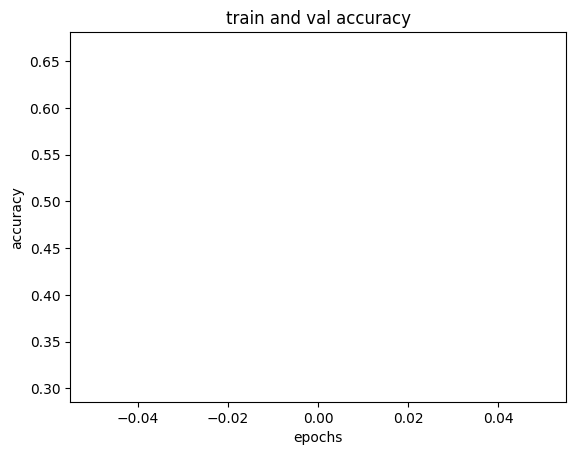

In [57]:
plt.plot(actualEpochs, acc, "r", label="train_acc")
plt.plot(actualEpochs, val_acc, "b", label="val_acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("train and val accuracy")
plt.show()
